# 图像处理系统的一般处理流程
> * 图像采样、图像预处理（包括去噪、复原、校正等）、图像分割
> * 生成训练数据集和测试数据集
> * 特征提取
> * 建立模型对像（分类、聚类、回归等）
> * 训练模型
> * 测试模型
> * 模型评价

In [3]:
# from sklearn.externals import joblib
from sklearn import datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC
import numpy as np
import os,math,cv2,struct
import matplotlib.pyplot as plt
%matplotlib inline
%config InlinBackend.figure_format="retina"
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负

#读取MNIST数据
#path是数据文件夹的路径，labelfile是图像标注文件名,datafile是数据文件名
def load_mnist(path,labelfile,datafile):            #读取数据函数
    #Load MNIST data from path
    labels_path = os.path.join(path, labelfile)
    images_path = os.path.join(path, datafile)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

#读取训练集    features是图片数据,labels是对应的标注
features,labels = load_mnist(r"../mnist",'train-labels-idx1-ubyte', 'train-images-idx3-ubyte')
print(features.shape,labels.shape)
# print(type(features),type(labels))

(60000, 784) (60000,)


训练集行数: 6000, 列数: 784


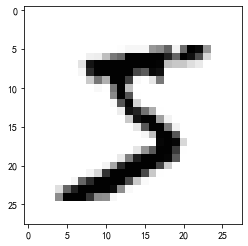

In [4]:
#显示训练数据
features=features[0:6000,:]
labels=labels[0:6000]
print('训练集行数: %d, 列数: %d' % (features.shape[0], features.shape[1]))
x=np.array(features[0,:])  #提取第一行数据
x = x.reshape([28, 28])
plt.figure(figsize=(12,4))
# plt.subplots_adjust(top=0,bottom=-1)
plt.imshow(x,cmap="Greys") 
plt.show()

In [6]:
# # 读取测试集
testfeatures,testlabels = load_mnist(r"../mnist",'t10k-labels-idx1-ubyte', 't10k-images-idx3-ubyte')
print('测试集行数: %d, 列数: %d' % (testfeatures.shape[0], testfeatures.shape[1]))

测试集行数: 10000, 列数: 784


In [7]:
#提取训练集HOG特征
list_hog_fd = [] 
for feature in features:
    fd = hog(feature.reshape((28, 28)),     # hog 特征
             orientations=9, 
             pixels_per_cell=(14, 14), 
             cells_per_block=(1, 1), 
             visualize=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')  #训练集的HOG特征
print(hog_features.shape)
#提取测试集HOG特征
list_hog_fd = [] 
for feature in testfeatures:
    fd = hog(feature.reshape((28, 28)),     # hog 特征
             orientations=9, 
             pixels_per_cell=(14, 14), 
             cells_per_block=(1, 1), 
             visualize=False)
    list_hog_fd.append(fd)
hog_testfeatures = np.array(list_hog_fd, 'float64')   #测试集的HOG
print(hog_testfeatures.shape)

(6000, 36)
(10000, 36)


# KNN分类算法
<img src="../img/knn.jpg"/>
## 使用KNN算法需要准备的参数

> * 准备输入、输出数据，划分训练集和测试集
> * K值
> * 迭代次数


In [8]:
# KNN分类器进行分类
from sklearn.neighbors import KNeighborsClassifier
k=5
kNN_model = KNeighborsClassifier(n_neighbors=k)  #建立KNN分类模型
kNN_model.fit(hog_features, labels)               #用训练集训练KNN模型
testnumber = kNN_model.predict(hog_testfeatures)   #对测试集中的图片进行预测，输出为测试集中各图片所属的类别
KNNscore = kNN_model.score(hog_testfeatures, testlabels) #输入测试集及标注，对测试结果进行评估，输出为分类精度
print("测试集第一个图像数字是：",testnumber[0])  #输出第一张测试图片所属类别
print("分类精度：",KNNscore)     #输出测试集的分类精度

测试集第一个图像数字是： 7
分类精度： 0.8372


In [9]:
#不使用HOG，而是提取图像的LBP直方图特征
g_mapping=[
    0, 1, 2, 3, 4, 58, 5, 6, 7, 58, 58, 58, 8, 58, 9, 10, 
    11, 58, 58, 58, 58, 58, 58, 58, 12, 58, 58, 58, 13, 58, 14, 15, 
    16, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 
    17, 58, 58, 58, 58, 58, 58, 58, 18, 58, 58, 58, 19, 58, 20, 21, 
    22, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 
    58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 
    23, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 
    24, 58, 58, 58, 58, 58, 58, 58, 25, 58, 58, 58, 26, 58, 27, 28, 
    29, 30, 58, 31, 58, 58, 58, 32, 58, 58, 58, 58, 58, 58, 58, 33, 
    58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 34, 
    58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 
    58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 35, 
    36, 37, 58, 38, 58, 58, 58, 39, 58, 58, 58, 58, 58, 58, 58, 40, 
    58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 41, 
    42, 43, 58, 44, 58, 58, 58, 45, 58, 58, 58, 58, 58, 58, 58, 46, 
    47, 48, 58, 49, 58, 58, 58, 50, 51, 52, 58, 53, 54, 55, 56, 57]

def LBP(I, radius=2, count=8):       #得到图像的LBP特征
    dh = np.round([radius*math.sin(i*2*math.pi/count) for i in range(count)])
    dw = np.round([radius*math.cos(i*2*math.pi/count) for i in range(count)])
    I=I.reshape(28, 28)
    height,width = I.shape
    lbp = np.zeros(I.shape, dtype = np.int)
    I1 = np.pad(I, radius, 'edge')
    for k in range(count):
        h,w = int(radius+dh[k]), int(radius+dw[k])
        lbp += ((I>I1[h:h+height, w:w+width])<<k)
    return lbp

def calLbpHistogram(lbp, hCount=7, wCount=5, maxLbpValue=255): #分块计算lbp直方图
    height,width = lbp.shape
    res = np.zeros((hCount*wCount, max(g_mapping)+1), dtype=np.float)
    assert(maxLbpValue+1 == len(g_mapping))
    
    for h  in range(hCount):
        for w in range(wCount):
            blk = lbp[height*h//hCount:height*(h+1)//hCount, width*w//wCount:width*(w+1)//wCount]
            hist1 = np.bincount(blk.ravel(), minlength=maxLbpValue)
            hist = res[h*wCount+w,:]
            for v,k in zip(hist1, g_mapping):
                hist[k] += v
            hist /= hist.sum()
    feature=res.reshape(res.shape[0]*res.shape[1],1)
    return res
lbp_features = np.array([calLbpHistogram(LBP(d)).ravel() for d in features])
lbp_testfeatures = np.array([calLbpHistogram(LBP(d)).ravel() for d in testfeatures])

In [10]:
#使用SVM支持向量机分类器进行分类
from sklearn.svm import LinearSVC
#建立并训练SVM模型
svm_model = LinearSVC()                                # 建立SVM模型
svm_model.fit(hog_features, labels)                    # 训练
# joblib.dump(clf, "digits_cls.pkl", compress=3)   # 模型保存

# #测试SVM模型
# svm_model = joblib.load("digits_cls.pkl") 
test_est = svm_model.predict(hog_testfeatures)   #测试单个图像，输出结果为图像所属类别
SVMscore = svm_model.score(hog_testfeatures, testlabels)
print("测试集第一个图像数字是：",testlabels[0])
print("HOG+SVM分类精度：",SVMscore)


测试集第一个图像数字是： 7
HOG+SVM分类精度： 0.8555


In [11]:
import sklearn.metrics as metrics
print("--------混淆矩阵-----------")
print(metrics.confusion_matrix(testlabels, test_est, labels=[0, 1,2,3,4,5,6,7,8,9]))  # 混淆矩阵
print("--------分类评估报告-----------")
print(metrics.classification_report(testlabels, test_est))

--------混淆矩阵-----------
[[ 913    5    9    2    3    4    4    6    7   27]
 [   7 1079    5    0   13    0   12   11    3    5]
 [  13    0  935   35   23    2    3   10    7    4]
 [   6    0   76  830   18   21    3    8   18   30]
 [  19    6   19    8  836    7   43    7   16   21]
 [   4    4    5   34    7  752   17    4   43   22]
 [  43    7    3    1   25   28  831    0   14    6]
 [  11    7   59   12   14    1    0  863   14   47]
 [  10    4   18   33   25   19   37   14  794   20]
 [  82   11   13   58   31   16   14   33   29  722]]
--------分类评估报告-----------
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       980
           1       0.96      0.95      0.96      1135
           2       0.82      0.91      0.86      1032
           3       0.82      0.82      0.82      1010
           4       0.84      0.85      0.85       982
           5       0.88      0.84      0.86       892
           6       0.86      0.87      0

In [49]:
print(testlabels.shape)

(10000,)


In [9]:
from sklearn.svm import LinearSVC
help(LinearSVC)

Help on class LinearSVC in module sklearn.svm.classes:

class LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
 |  
 |  Linear Support Vector Classification.
 |  
 |  Similar to SVC with parameter kernel='linear', but implemented in terms of
 |  liblinear rather than libsvm, so it has more flexibility in the choice of
 |  penalties and loss functions and should scale better to large numbers of
 |  samples.
 |  
 |  This class supports both dense and sparse input and the multiclass support
 |  is handled according to a one-vs-the-rest scheme.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  penalty : string, 'l1' or 'l2' (default='l2')
 |      Specifie

In [13]:
#随机森林分类
from sklearn.ensemble import RandomForestClassifier  
rf_model = RandomForestClassifier()
rf_model.fit(hog_features, labels) 
testnumber = rf_model.predict(hog_testfeatures)   #测试单个图像，输出结果为图像所属类别
rf_score = rf_model.score(hog_testfeatures, testlabels)
print("第一个图像数字是：",testnumber[0])
print("分类精度：",rf_score)



C:\Users\zy\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


第一个图像数字是： 7
分类精度： 0.819


In [14]:
# #逻辑回归分类
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(hog_features, labels) 
testnumber = lr_model.predict(hog_testfeatures)   #测试单个图像，输出结果为图像所属类别
lr_score = lr_model.score(hog_testfeatures, testlabels)
print("第一个图像数字是：",testnumber[0])
print("分类精度：",lr_score)

C:\Users\zy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


第一个图像数字是： 7
分类精度： 0.853


In [ ]:
'''练习：实现HOG+KNN，HOG+SVM,HOG+随机森林分类，HOG+逻辑回归
以及LBP+KNN，LBP+SVM,LBP+随机森林分类，LBP+逻辑回归的手写数字识别，比较他们的识别精度
'''


In [5]:
help( cv2.adaptiveThreshold)

Help on built-in function adaptiveThreshold:

adaptiveThreshold(...)
    adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst]) -> dst
    .   @brief Applies an adaptive threshold to an array.
    .   
    .   The function transforms a grayscale image to a binary image according to the formulae:
    .   -   **THRESH_BINARY**
    .   \f[dst(x,y) =  \fork{\texttt{maxValue}}{if \(src(x,y) > T(x,y)\)}{0}{otherwise}\f]
    .   -   **THRESH_BINARY_INV**
    .   \f[dst(x,y) =  \fork{0}{if \(src(x,y) > T(x,y)\)}{\texttt{maxValue}}{otherwise}\f]
    .   where \f$T(x,y)\f$ is a threshold calculated individually for each pixel (see adaptiveMethod parameter).
    .   
    .   The function can process the image in-place.
    .   
    .   @param src Source 8-bit single-channel image.
    .   @param dst Destination image of the same size and the same type as src.
    .   @param maxValue Non-zero value assigned to the pixels for which the condition is satisfied
    .   @p